In [1]:
import torch
import numpy as np
import models
import data
import pydicom as dicom
import cv2
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

model_path = '/home/tstrebel/repos/umich-mads-capstone-project/models/rsna-densenet.ckpt'
patient_data_path = '/home/tstrebel/repos/umich-mads-capstone-project/assets/rsna-patient-details.csv'
bb_path = '/home/tstrebel/assets/rsna-pneumonia/stage_2_train_labels.csv.zip'
img_dir = '/home/tstrebel/assets/rsna-pneumonia/train-images/'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

TL_THRESH = 0.406

In [2]:
df_test = pd.read_csv(patient_data_path, index_col='index')
df_test = df_test[df_test['split'] == 'test']

dataset = data.get_dataset(img_dir, df_test)

df_bb = (pd.read_csv(bb_path).rename({ 'patientId':'patient_id', 'Target':'target' }, axis=1))

model = models.Densenet121GradCam()
state_dict = torch.load(model_path, map_location=device)['state_dict']
_ = model.load_state_dict(state_dict)
model = model.to(device)

In [21]:
# Implementation adapted from https://medium.com/@stepanulyanin/implementing-grad-cam-in-pytorch-ea0937c31e82
def show_gradcam(img_dir:str, 
                 model:torch.nn.Module, 
                 patient:pd.Series, 
                 inputs:torch.Tensor, 
                 df_bb:pd.DataFrame,
                 save_path:str=None):

    model.eval()
    
    outputs = model(inputs)
    model.zero_grad()
    outputs.backward()
    
    with torch.no_grad():
        # pull the gradients out of the model
        gradients = model.get_activations_gradient()
        # pool the gradients across the channels
        pooled_gradients = torch.mean(gradients, dim=[0, 2, 3])
        # get the activations of the last convolutional layer
        activations = model.get_activations(inputs)
        # weight the channels by corresponding gradients
        for i in range(pooled_gradients.shape[0]):
            activations[:, i, :, :] *= pooled_gradients[i]
        # average the channels of the activations
        heatmap = torch.mean(activations, dim=1).squeeze()
    # relu on top of the heatmap
    # expression (2) in https://arxiv.org/pdf/1610.02391.pdf
    heatmap = np.maximum(heatmap.cpu(), 0)
    # normalize the heatmap
    heatmap /= torch.max(heatmap)

    img_path = ''.join([img_dir, '/', patient.patient_id, '.dcm'])

    image = dicom.dcmread(img_path)
    
    heatmap_x = cv2.resize(heatmap.numpy(), (448, 448))
    heatmap_x = np.pad(heatmap_x, 32)
    heatmap_x = cv2.resize(heatmap_x, (image.pixel_array.shape[1], image.pixel_array.shape[0]))
    heatmap_x = np.uint8(255 * heatmap_x)
    heatmap_x = cv2.applyColorMap(heatmap_x, cv2.COLORMAP_HOT)
    
    image = cv2.cvtColor(image.pixel_array, cv2.COLOR_GRAY2RGB)
    image_x = cv2.addWeighted(image, 1.0, heatmap_x, .3, 1.0)
    # Draw bounding box
    if patient.patient_id in df_bb[~df_bb.x.isnull()].patient_id.tolist():
        for row in df_bb[df_bb.patient_id==patient.patient_id].iloc[:, 1:-1].values:
            x, y, w, h = np.int64(row)
            image_x = cv2.rectangle(image_x, (x, y), (x+w, y+h), (255, 0, 0), 7)
            
    fig, (ax1, ax2) = plt.subplots(ncols=2, dpi=300)
    ax1.imshow(image)
    ax2.imshow(image_x)
    
    ax1.axis('off')
    ax2.axis('off')
    fig.tight_layout()
    
    if save_path:
        plt.savefig(save_path, format='png', orientation='landscape')
        
    print('Class:', patient['class'])
    print('Age:', patient.patient_age)
    print('Sex:', patient.patient_sex)
    print('View Position:', patient.view_position)
    print('Probability:', patient.rsna_densenet_proba)
    print('Prediction Threshold:', TL_THRESH)
        
    plt.show()

Class: Lung Opacity
Age: 2
Sex: M
View Position: AP
Probability: 0.73981273
Prediction Threshold: 0.406


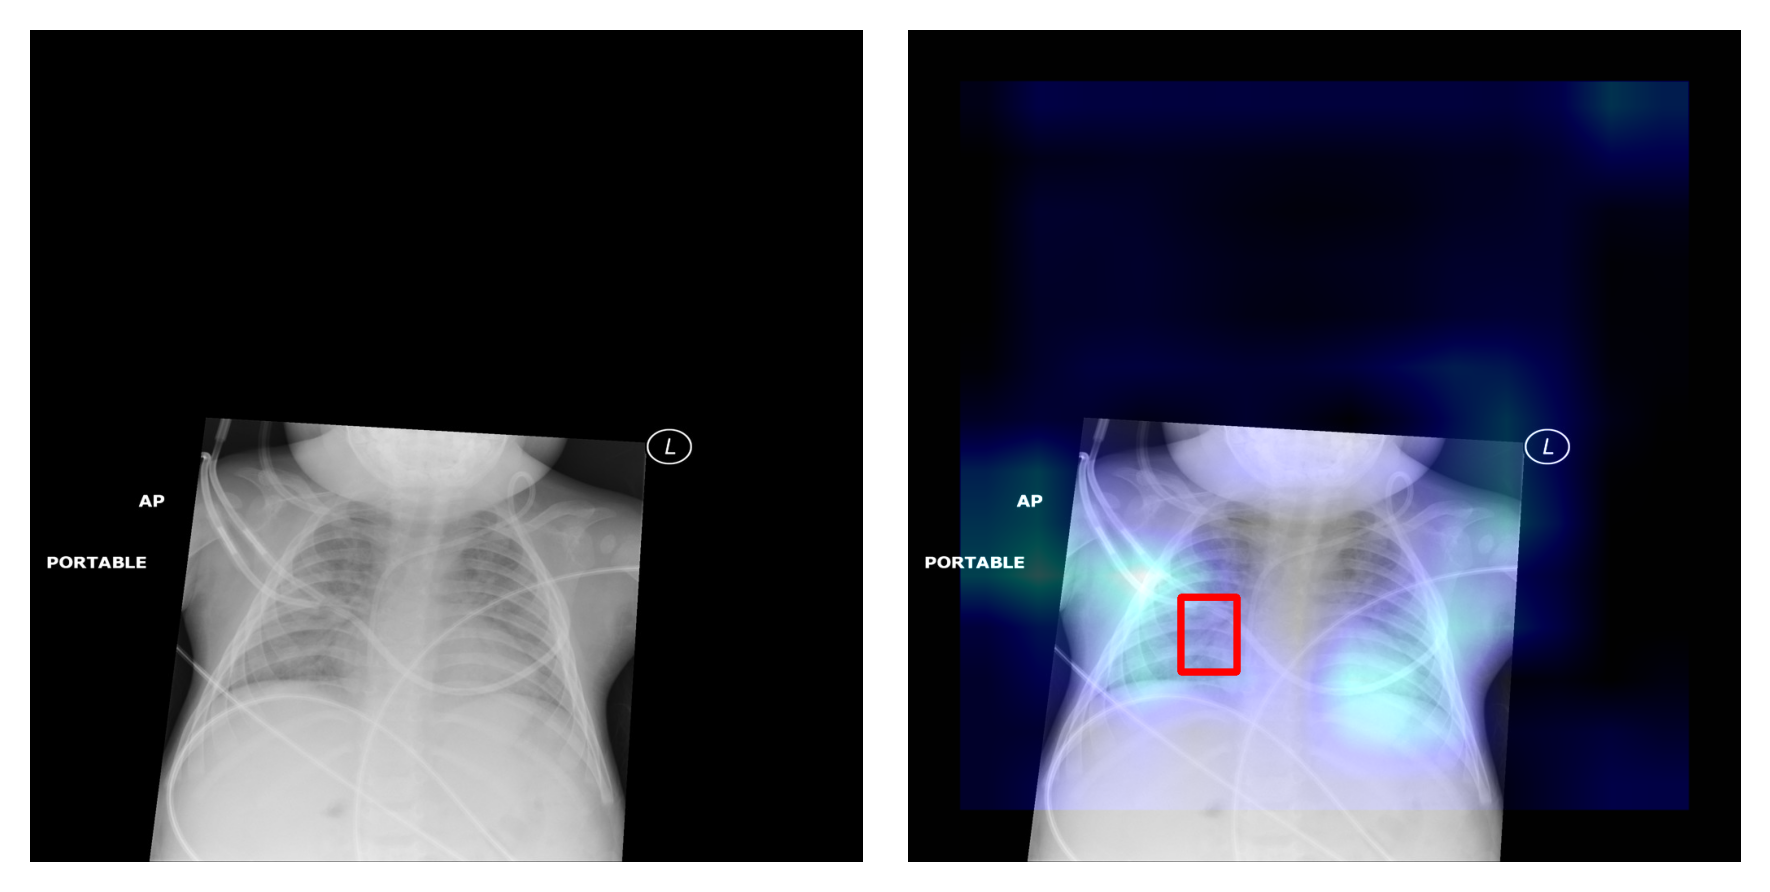

In [47]:
patient = df_test[(df_test.patient_age < 5) & (df_test.target==1)].sample(1).iloc[0]

idx = np.where(df_test.patient_id==patient.patient_id)[0][0]
inputs, target = dataset[idx]

inputs = inputs.unsqueeze(dim=0).to(device)
target = target.to(device)

save_path=None
# save_path = '/home/tstrebel/repos/umich-mads-capstone-project/figures/infant.png'
    
show_gradcam(img_dir, 
             model, 
             patient, 
             inputs, 
             df_bb,
             save_path=save_path)